Interconnect, a telecom provider offering landline, internet, and various add-on services (security tools, tech support, cloud backups, and streaming), wants to predict which customers are likely to churn. When a customer is identified as at risk of leaving, the company plans to offer special discounts and customized plan options to retain them.

To support this, Interconnect’s marketing team has compiled several datasets containing client information—contract details, personal data, internet services, and phone services—linked by a unique customerID. The contract data reflects each customer’s status as of February 1, 2020.

The goal of this project is to build a predictive model that determines whether a customer is likely to churn, using EndDate = 'No' as the target label. Model performance will be evaluated primarily with AUC-ROC, with accuracy as an additional metric. Higher AUC-ROC scores correspond to higher project scoring, with 0.88+ earning the maximum.

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
from operator import attrgetter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [22]:
contract = pd.read_csv(r'C:\Users\pjlaf\OneDrive\Documents\job\python for portfolio\contract.csv')
personal = pd.read_csv(r'C:\Users\pjlaf\OneDrive\Documents\job\python for portfolio\personal.csv')
internet = pd.read_csv(r'C:\Users\pjlaf\OneDrive\Documents\job\python for portfolio\internet.csv')
phone = pd.read_csv(r'C:\Users\pjlaf\OneDrive\Documents\job\python for portfolio\phone.csv')

In [23]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [24]:
contract.columns = contract.columns.str.lower()
contract.rename(columns=
{'customerid':'customer_id', 'begindate':'begin_date', 'enddate':'end_date', 'paperlessbilling':'paperless_billing', 'paymentmethod':'payment_method',
'monthlycharges':'monthly_charges', 'totalcharges':'total_charges'}, inplace=True)

In [25]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

In [26]:
contract['type'].value_counts()

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [27]:
contract['paperless_billing'].value_counts()

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64

In [28]:
contract['payment_method'].value_counts()

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [29]:
print(contract['total_charges'].value_counts())
# there are customers that have no value for total charge column. That is OK, but the value should be '0' not ' ' 
# this way we can have the column be float type rather than object type
contract['total_charges'] = contract['total_charges'].replace({' ':0})
contract['total_charges'] = contract['total_charges'].astype('float')

total_charges
20.2      11
          11
19.75      9
19.65      8
19.9       8
          ..
1990.5     1
7362.9     1
346.45     1
306.6      1
108.15     1
Name: count, Length: 6531, dtype: int64


In [30]:
personal.columns = personal.columns.str.lower()
personal.rename(columns={
    'customerid':'customer_id', 'seniorcitizen':'senior_citizen', 'Partner':'partner', 'Dependents':'dependents'
},inplace=True)

In [31]:
personal['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [32]:
personal['senior_citizen'].value_counts()

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

In [33]:
personal['partner'].value_counts()

partner
No     3641
Yes    3402
Name: count, dtype: int64

In [34]:
personal['dependents'].value_counts()

dependents
No     4933
Yes    2110
Name: count, dtype: int64

In [35]:
internet.columns = internet.columns.str.lower()
internet.rename(columns={
    'customerid':'customer_id', 'internetservice':'internet_service', 'onlinesecurity':'online_security', 'onlinebackup':'online_backup',
    'deviceprotection':'device_protection', 'techsupport':'tech_support', 'streamingtv':'streaming_tv', 'streamingmovies':'streaming_movies'
},inplace=True)

In [36]:
for column in internet.columns:
    print(f'Column: {column}\n{internet[column].value_counts()}\n')

Column: customer_id
customer_id
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
3668-QPYBK    1
7795-CFOCW    1
             ..
4190-MFLUW    1
4183-MYFRB    1
8779-QRDMV    1
3638-WEABW    1
6322-HRPFA    1
Name: count, Length: 5517, dtype: int64

Column: internet_service
internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Column: online_security
online_security
No     3498
Yes    2019
Name: count, dtype: int64

Column: online_backup
online_backup
No     3088
Yes    2429
Name: count, dtype: int64

Column: device_protection
device_protection
No     3095
Yes    2422
Name: count, dtype: int64

Column: tech_support
tech_support
No     3473
Yes    2044
Name: count, dtype: int64

Column: streaming_tv
streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64

Column: streaming_movies
streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64



In [37]:
phone.columns = phone.columns.str.lower()
phone.rename(columns={
    'customerid':'customer_id', 'multiplelines':'multiple_lines'
},inplace=True)
phone['multiple_lines'].value_counts()

multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

In [38]:
len(contract['customer_id'].unique())

7043

In [39]:
for column in [contract,personal,internet,phone]:
    print(column.columns)
    print()

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Index(['customer_id', 'multiple_lines'], dtype='object')



In [40]:
customer = contract.merge(personal, on='customer_id', how='inner')

In [41]:
customer = customer.merge(internet, on='customer_id', how='left')

In [42]:
customer = customer.merge(phone, on='customer_id', how='left')

In [43]:
customer.shape

(7043, 20)

In [44]:
customer.isnull().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [45]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [46]:
internet_columns = ['internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']
for col in internet_columns:
    customer[col].fillna('No internet service', inplace=True)
print(customer.isna().sum())
print()

for i in internet_columns:
    print(customer[i].value_counts())
    print()

customer_id            0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
gender                 0
senior_citizen         0
partner                0
dependents             0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
multiple_lines       682
dtype: int64

internet_service
Fiber optic            3096
DSL                    2421
No internet service    1526
Name: count, dtype: int64

online_security
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

online_backup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

device_protection
No                     3095
Yes                    2422
No internet service    1526
Name

C:\Users\pjlaf\AppData\Local\Temp\ipykernel_4560\4114416857.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer[col].fillna('No internet service', inplace=True)


In [47]:
customer['multiple_lines'].value_counts()

multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

In [48]:
customer['multiple_lines'].fillna('No phone service', inplace=True)

C:\Users\pjlaf\AppData\Local\Temp\ipykernel_4560\1133669337.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer['multiple_lines'].fillna('No phone service', inplace=True)


In [49]:
print(customer.shape)
print()
customer.info()

(7043, 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 

In [50]:
customer.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No phone service
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone service
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [51]:
print(customer['begin_date'].max(), '\t\t', customer['begin_date'].min())

2020-02-01 00:00:00 		 2013-10-01 00:00:00


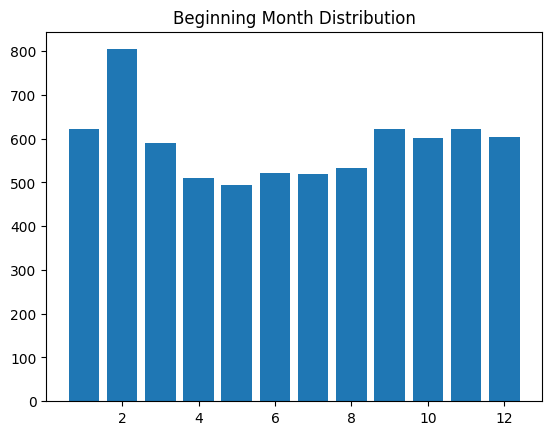

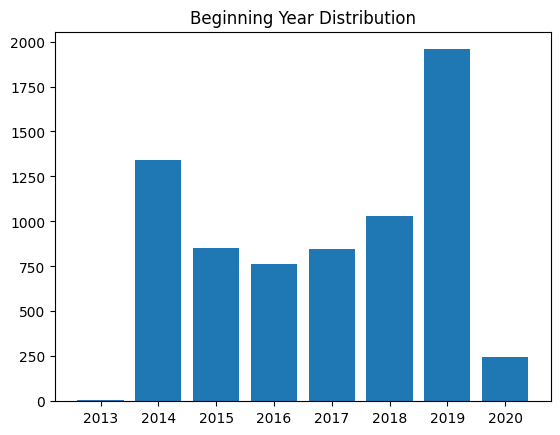

In [52]:
# extrapolate month and year from begin date column.
customer['begin_month'] = customer['begin_date'].dt.month
customer['begin_year'] = customer['begin_date'].dt.year
month_counts = customer['begin_month'].value_counts()
plt.bar(month_counts.index, month_counts.values)
plt.title('Beginning Month Distribution')
plt.show()
year_counts = customer['begin_year'].value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.title('Beginning Year Distribution')
plt.show()

In [54]:
def count_premium_services(row, **kwargs):
    services = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                'streaming_tv', 'streaming_movies', 'multiple_lines']
    count = 0
    
    for service in services:
        if service == 'internet_service':
            if row[service] != 'No internet service':
                count +=1
        else:
            if row[service] == 'Yes':
                count += 1
    return count
customer['premium_services'] = customer.apply(count_premium_services, axis=1)

In [55]:
current_date = pd.to_datetime('2020-02-01')

tenure_period = current_date.to_period('M') - customer['begin_date'].dt.to_period('M')
    
customer['tenure_months'] = tenure_period.apply(lambda x: x.n)
customer.head() 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_month,begin_year,premium_services,tenure_months
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,Yes,No,No,No,No,No phone service,1,2020,2,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,Yes,No,No,No,No,4,2017,3,34
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,No,No,No,No,No,10,2019,3,4
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,Yes,Yes,No,No,No phone service,5,2016,4,45
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,9,2019,1,5


In [56]:
customer['begin_date'].min()

Timestamp('2013-10-01 00:00:00')

In [57]:
def lifecycle(months):
    if months < 13:
        return 'New'
    elif months < 37:
        return 'Established'
    else:
        return 'Loyal'
customer['lifecycle_stage'] = customer['tenure_months'].apply(lifecycle)

In [58]:
customer['average_monthly_rev'] = customer['total_charges'] / customer['tenure_months']
# leaves us with missing values
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   object        
 3   type                 7043 non-null   object        
 4   paperless_billing    7043 non-null   object        
 5   payment_method       7043 non-null   object        
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   gender               7043 non-null   object        
 9   senior_citizen       7043 non-null   int64         
 10  partner              7043 non-null   object        
 11  dependents           7043 non-null   object        
 12  internet_service     7043 non-null   object        
 13  online_security      7043 non-nul

In [59]:
customer['average_monthly_rev'].fillna(customer['monthly_charges'], inplace=True)

C:\Users\pjlaf\AppData\Local\Temp\ipykernel_4560\1890474880.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer['average_monthly_rev'].fillna(customer['monthly_charges'], inplace=True)


In [60]:
customer['payment_method'].value_counts()

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [61]:
def ease_of_payment(method):
    if 'automatic' in method.lower():
        return 'Automatic'
    elif 'electronic' in method.lower():
        return 'Electronic'
    else:
        return 'Manual'
customer['payment_category'] = customer['payment_method'].apply(ease_of_payment)

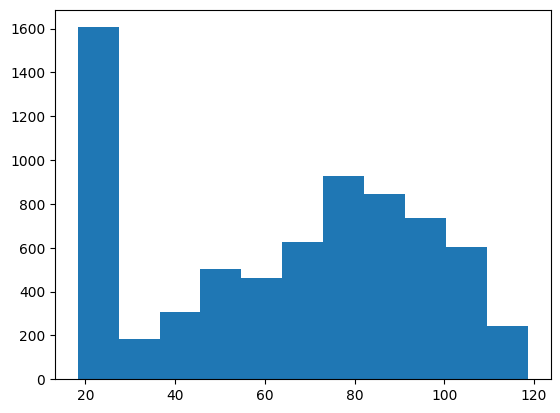

In [62]:
plt.hist(customer['monthly_charges'],bins=11)
plt.show()

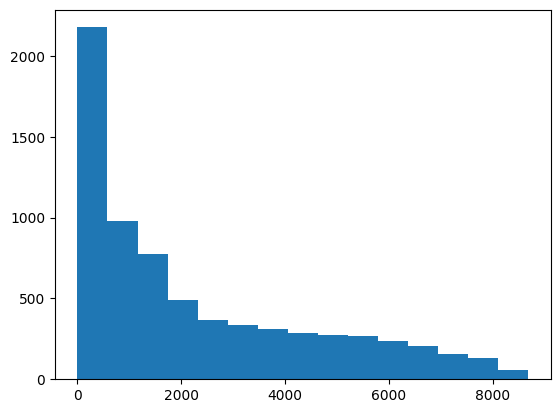

In [63]:
plt.hist(customer['total_charges'], bins=15)
plt.show()

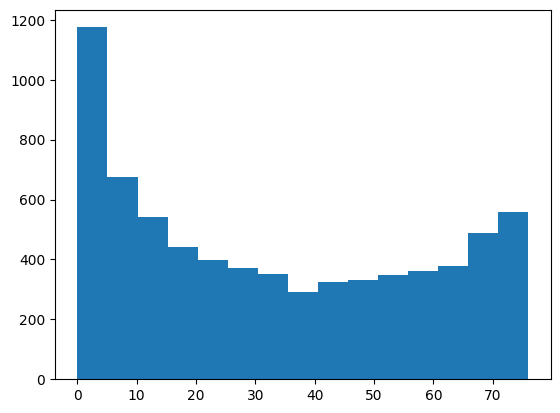

In [64]:
plt.hist(customer['tenure_months'],bins=15)
plt.show()

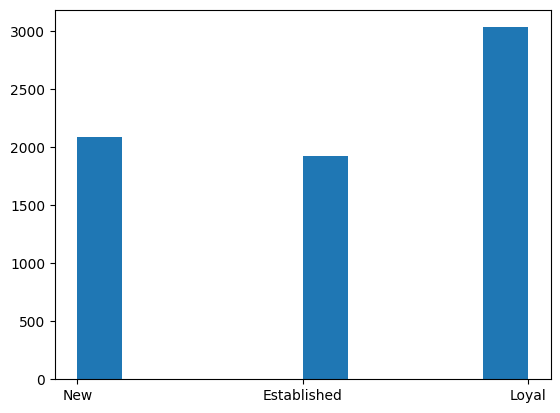

In [65]:
plt.hist(customer['lifecycle_stage'])
plt.show()

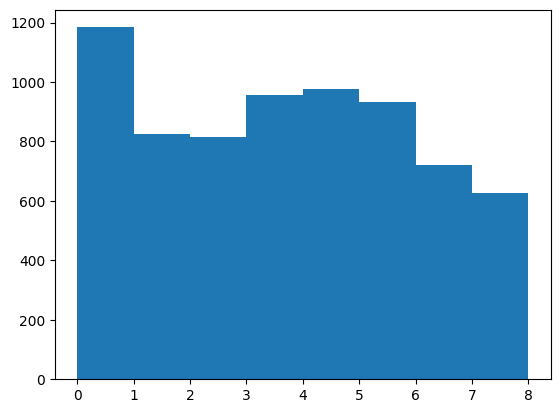

In [66]:
plt.hist(customer['premium_services'],bins=8)
plt.show()

In [67]:
def churned(row):
    if row != 'No':
        return 1
    else:
        return 0
customer['churn'] = customer['end_date'].apply(churned)

In [68]:
print(customer['churn'].value_counts())
print()
print(customer['end_date'].value_counts())
print()
print('Churn Rate',len(customer[customer['churn']==1])/len(customer['churn']))

churn
0    5174
1    1869
Name: count, dtype: int64

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Churn Rate 0.2653698707936959


In [69]:
customer.groupby('type')['churn'].mean()

type
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: churn, dtype: float64

In [70]:
customer.groupby(['gender','senior_citizen'])['churn'].mean()

gender  senior_citizen
Female  0                 0.239384
        1                 0.422535
Male    0                 0.232808
        1                 0.411150
Name: churn, dtype: float64

In [71]:
customer.groupby('payment_method')['churn'].mean()

payment_method
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: churn, dtype: float64

In [72]:
customer.groupby('payment_category')['churn'].mean()

payment_category
Automatic     0.159817
Electronic    0.452854
Manual        0.191067
Name: churn, dtype: float64

In [74]:
customer.groupby('premium_services')[['churn','average_monthly_rev']].mean()

,churn,average_monthly_rev
premium_services,,
0,0.086993,19.155086
1,0.306667,33.277659
2,0.476716,49.372593
3,0.377220,60.672921
4,0.312883,70.265965
5,0.257235,81.499404
6,0.217452,89.405328
7,0.116667,96.580368
8,0.052885,104.470594


In [76]:
customer.groupby('lifecycle_stage')[['churn','average_monthly_rev']].mean()

,churn,average_monthly_rev
lifecycle_stage,,
Established,0.282078,60.640791
Loyal,0.128011,71.638066
New,0.449449,41.313154


In [77]:
num_cols = ['monthly_charges','total_charges','senior_citizen','begin_month','begin_year','premium_services','tenure_months','average_monthly_rev','churn']
matrix = customer[num_cols].corr()
matrix

,monthly_charges,total_charges,senior_citizen,begin_month,begin_year,premium_services,tenure_months,average_monthly_rev,churn
monthly_charges,1.000000,0.651174,0.220173,-0.018072,-0.264251,0.821725,0.260853,0.916766,0.193356
total_charges,0.651174,1.000000,0.103006,-0.194289,-0.819539,0.763796,0.829438,0.760110,-0.198324
senior_citizen,0.220173,0.103006,1.000000,0.029381,-0.028418,0.117287,0.023422,0.179062,0.150889
begin_month,-0.018072,-0.194289,0.029381,1.000000,0.081542,-0.109896,-0.227521,-0.110691,0.181417
begin_year,-0.264251,-0.819539,-0.028418,0.081542,1.000000,-0.474898,-0.989083,-0.407206,0.291621
premium_services,0.821725,0.763796,0.117287,-0.109896,-0.474898,1.000000,0.480236,0.837827,-0.020953
tenure_months,0.260853,0.829438,0.023422,-0.227521,-0.989083,0.480236,1.000000,0.414217,-0.311744
average_monthly_rev,0.916766,0.760110,0.179062,-0.110691,-0.407206,0.837827,0.414217,1.000000,-0.087546
churn,0.193356,-0.198324,0.150889,0.181417,0.291621,-0.020953,-0.311744,-0.087546,1.000000


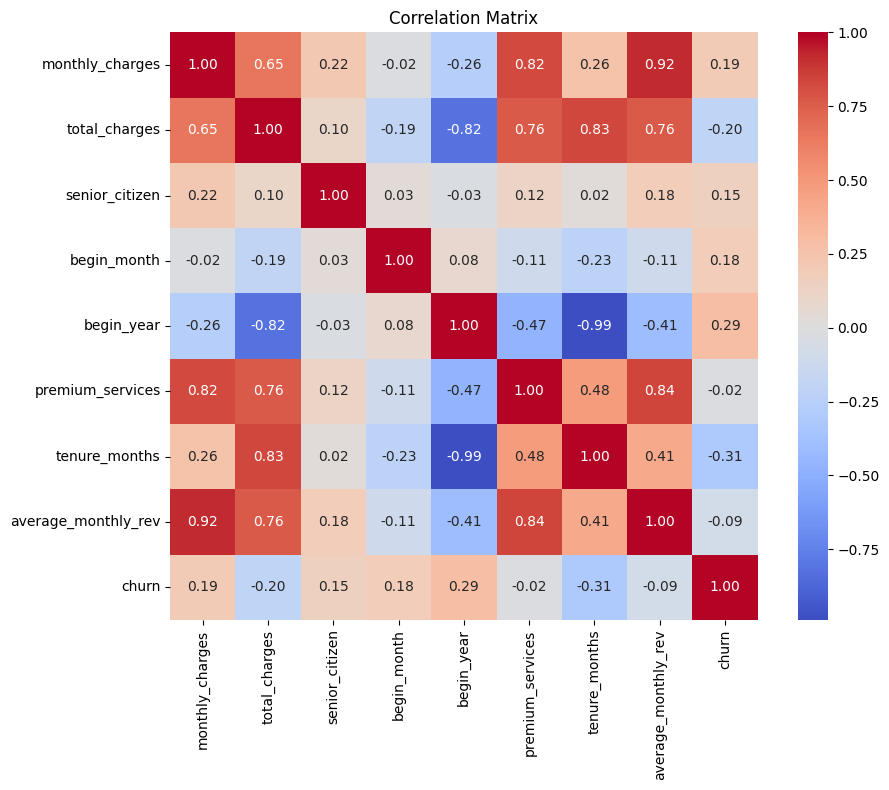

In [78]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix,annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [79]:
services = ['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines']

def adoption_rate(df, service):
    adopted = df[df[service]=='Yes'].shape[0]
    eligible = df[df[service].isin(['Yes','No'])].shape[0]
    return adopted / eligible if eligible > 0 else 0

for service in services:
    rate = adoption_rate(customer, service)
    print(f'{service} {rate*100:.2f}% adoption rate\n')


online_security 36.60% adoption rate

online_backup 44.03% adoption rate

device_protection 43.90% adoption rate

tech_support 37.05% adoption rate

streaming_tv 49.07% adoption rate

streaming_movies 49.52% adoption rate

multiple_lines 46.71% adoption rate



In [80]:
X = customer.drop(['customer_id','end_date','churn','begin_date'],axis=1) 
y = customer['churn']

In [81]:
dupes = X.duplicated()
X.drop_duplicates(inplace=True)
y = y[~dupes]
print(X.shape)
print(y.shape)

(7030, 24)
(7030,)


In [82]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,y, test_size=0.40, random_state=12345, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=.50, random_state=12345, stratify=y_temp
)

print(X_train.shape)
print(y_train.shape)
print()
print(X_valid.shape)
print(y_valid.shape)
print()
print(X_test.shape)
print(y_test.shape)

(4218, 24)
(4218,)

(1406, 24)
(1406,)

(1406, 24)
(1406,)


In [83]:
categorical_cols = X_train.select_dtypes(['object']).columns.to_list()
numerical_cols = ['monthly_charges','total_charges','senior_citizen','begin_month','begin_year','premium_services','tenure_months','average_monthly_rev']

In [87]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error')

encoder.fit(X_train[categorical_cols])

X_train_encoded = encoder.transform(X_train[categorical_cols])
X_valid_encoded = encoder.transform(X_valid[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

features = encoder.get_feature_names_out(categorical_cols)


X_train_cat = pd.DataFrame(X_train_encoded, columns=features, index=X_train.index)
X_valid_cat = pd.DataFrame(X_valid_encoded, columns=features, index=X_valid.index)
X_test_cat = pd.DataFrame(X_test_encoded, columns=features, index=X_test.index)

X_train_num = X_train[numerical_cols]
X_valid_num = X_valid[numerical_cols]
X_test_num = X_test[numerical_cols]

X_train_complete = pd.concat([X_train_cat,X_train_num], axis=1)
X_valid_complete = pd.concat([X_valid_cat, X_valid_num], axis=1)
X_test_complete = pd.concat([X_test_cat, X_test_num], axis=1)

In [88]:
X_train_complete.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,...,payment_category_Electronic,payment_category_Manual,monthly_charges,total_charges,senior_citizen,begin_month,begin_year,premium_services,tenure_months,average_monthly_rev
2845,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,94.20,999.90,0,3,2019,5,11,90.900000
2907,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,89.00,1820.45,0,2,2018,3,24,75.852083
3974,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,79.25,2911.80,0,1,2017,6,37,78.697297
3623,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,72.25,2575.45,1,1,2017,1,37,69.606757
1320,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,94.80,3131.55,0,6,2017,5,32,97.860938


In [89]:
X_test_complete.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,...,payment_category_Electronic,payment_category_Manual,monthly_charges,total_charges,senior_citizen,begin_month,begin_year,premium_services,tenure_months,average_monthly_rev
5864,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,19.65,921.55,0,3,2016,0,47,19.607447
2100,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,99.50,6841.45,0,5,2014,5,69,99.151449
3807,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,104.65,2542.45,0,11,2017,6,27,94.164815
5850,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,71.30,1389.20,1,4,2018,1,22,63.145455
4825,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,83.05,1799.30,0,4,2018,3,22,81.786364


In [90]:
best_depth=0
best_score=0
best_model=None

for i in range(1,8):
    model_1 = DecisionTreeClassifier(max_depth=i,random_state=12345)
    model_1.fit(X_train_complete,y_train)
    pred = model_1.predict(X_valid_complete)
    score = roc_auc_score(y_valid,pred)
    if score > best_score:
        best_score = score
        best_depth = i
        best_model = model_1
print(best_score)
print(best_depth)
print(best_model)

0.8409678984918598
6
DecisionTreeClassifier(max_depth=6, random_state=12345)


In [91]:
best_depth=0
best_n = 0
best_score=0
best_model=None

for i in range(1,50,5):
    for j in range(1,9):
        model_2 = RandomForestClassifier(max_depth=j, n_estimators=i, random_state=12345)
        model_2.fit(X_train_complete, y_train)
        pred_2 = model_2.predict(X_valid_complete)
        score_2 = roc_auc_score(y_valid, pred_2)
        if score_2 > best_score:
            best_score = score_2
            best_model = model_2
            best_n = i
            best_depth = j
print(best_depth)
print(best_n)
print(best_score)
print(best_model)

8
41
0.7862313104547259
RandomForestClassifier(max_depth=8, n_estimators=41, random_state=12345)


In [92]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(X_train_complete, y_train)
pred_3 = model_3.predict(X_valid_complete)
score_3 = roc_auc_score(y_valid, pred_3)
score_3

c:\Users\pjlaf\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8940655422011944

In [93]:
model_4 = GradientBoostingClassifier(random_state=12345)
model_4.fit(X_train_complete,y_train)
pred_4 = model_4.predict(X_valid_complete)
score_4 = roc_auc_score(y_valid,pred_4)
score_4

0.8598086211326493

In [94]:
model_5 = XGBClassifier(random_state=12345)
model_5.fit(X_train_complete, y_train)
pred_5 = model_5.predict(X_valid_complete)
score_5 = roc_auc_score(y_valid, pred_5)
score_5

0.8879963873151159

In [95]:
model_6 = LGBMClassifier(random_state=12345)
model_6.fit(X_train_complete, y_train)
pred_6 = model_6.predict(X_valid_complete)
score_6 = roc_auc_score(y_valid, pred_6)
score_6

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1120, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 4218, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265529 -> initscore=-1.017428
[LightGBM] [Info] Start training from score -1.017428


0.8823736274003462

In [96]:
final_predict = model_3.predict(X_test_complete)
final_score = roc_auc_score(y_test, final_predict)
print(f'The final ROC-AUC of our highest preforming model is {final_score}')

The final ROC-AUC of our highest preforming model is 0.8927250596274678
